<a href="https://colab.research.google.com/github/srirampattabiraman/Computer-vision/blob/master/S5/EVA4_S5_Step2_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Target :

- Fix on the base model to increase its accuracy
- Model will run exactly 15 Epochs

### Result : - Total params: 9,840


### Analysis : 

- Using Base model.
- Introduced Image augumentation
- Changed the Input & Output channels and Kernal size + Batch Normalisation & Dropouts
- Max Accuracy > 99.4 only once within 15 epochs
- Parameters are reduced to <10K

### Action :
- Need more tuning

In [0]:
### Model Spec


In [0]:
## Importing the Libraries 

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
## Transformation

# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
## Data Set - trian test split 

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
## Data Loader arguments : Train Test arguments 

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [5]:
## Data Statistics 

# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
'''train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')'''

"train_data = train.train_data\ntrain_data = train.transform(train_data.numpy())\n\nprint('[Train]')\nprint(' - Numpy Shape:', train.train_data.cpu().numpy().shape)\nprint(' - Tensor Shape:', train.train_data.size())\nprint(' - min:', torch.min(train_data))\nprint(' - max:', torch.max(train_data))\nprint(' - mean:', torch.mean(train_data))\nprint(' - std:', torch.std(train_data))\nprint(' - var:', torch.var(train_data))\n\ndataiter = iter(train_loader)\nimages, labels = dataiter.next()\n\nprint(images.shape)\nprint(labels.shape)\n\n# Let's visualize some of the images\n%matplotlib inline\nimport matplotlib.pyplot as plt\n\nplt.imshow(images[0].numpy().squeeze(), cmap='gray_r')"

In [6]:
## View more images to know more images : Can give idea for transformation 

'''figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')'''

"figure = plt.figure()\nnum_of_images = 60\nfor index in range(1, num_of_images + 1):\n    plt.subplot(6, 10, index)\n    plt.axis('off')\n    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')"

In [5]:
## How we got the mean and standard deviaion values 

# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Sequential(
                                nn.Conv2d(in_channels=1,out_channels=10,kernel_size=(3, 3), padding=0, bias=False),
                                nn.ReLU(),
                                nn.BatchNorm2d(10),
                                nn.Dropout2d(0.05),
                                # output_size = 26
                                nn.Conv2d(in_channels=10,out_channels=20,kernel_size=(3, 3), padding=0, bias=False),
                                nn.ReLU(),
                                nn.BatchNorm2d(20),
                                nn.Dropout2d(0.05),
                                # output_size = 24
                                nn.Conv2d(in_channels=20,out_channels=16,kernel_size=(1, 1), padding=0, bias=False),
                                nn.ReLU(),
                                nn.MaxPool2d(2,2)
                                # output_size = 12
                                )

    self.conv2 = nn.Sequential(
                                nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3, 3), padding=0, bias=False),
                                nn.ReLU(),
                                nn.BatchNorm2d(16),
                                nn.Dropout2d(0.05),
                                # output_size = 10
                                nn.Conv2d(in_channels=16,out_channels=20,kernel_size=(3, 3), padding=0, bias=False),
                                nn.ReLU(),
                                nn.BatchNorm2d(20),
                                nn.Dropout2d(0.05),
                                # output_size = 8
                                nn.Conv2d(in_channels=20,out_channels=12,kernel_size=(3, 3), padding=0, bias=False),
                                nn.ReLU(),
                                nn.BatchNorm2d(12),
                                nn.Dropout2d(0.05),
                                # output_size = 6
                                )
    self.gap = nn.Sequential(
                                nn.AvgPool2d(kernel_size=6)
                                )
                                #output_size = 1
    
    self.conv4 = nn.Sequential(
                                nn.Conv2d(12,10,1),nn.ReLU()
                                
                                )

## Batchnorm () - Comment

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    #x = self.conv3(x)
    x = self.gap(x)
    x = self.conv4(x)
    x = x.view(-1,10)

    return F.log_softmax(x)

In [0]:
### The Model 9 : CHANGING THE IMAGE AUGMENTATION ### Above code -- Check rotaiton of the images ## ROTATE BEFORE CONERTING TO TENSOR ## We cna do after also, But not after normalisation

In [0]:
### The Model 10 :: OVER KiLl 

### Using the LR Scheduler

In [11]:
## Model Parameters

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
         Dropout2d-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 16, 24, 24]             320
             ReLU-10           [-1, 16, 24, 24]               0
        MaxPool2d-11           [-1, 16, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           2,304
             ReLU-13           [-1, 16, 10, 10]               0
      BatchNorm2d-14           [-1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
### Training & testing 

from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [13]:
## Train and test our model 

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)
EPOCHS = 16
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.19915656745433807 Batch_id=468 Accuracy=85.44: 100%|██████████| 469/469 [00:13<00:00, 34.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0609, Accuracy: 9826/10000 (98.26%)

EPOCH: 1


Loss=0.07450751215219498 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:13<00:00, 35.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9867/10000 (98.67%)

EPOCH: 2


Loss=0.12393132597208023 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:12<00:00, 37.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


Loss=0.020843416452407837 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:12<00:00, 37.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9895/10000 (98.95%)

EPOCH: 4


Loss=0.1389947086572647 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.014178787358105183 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:13<00:00, 35.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9923/10000 (99.23%)

EPOCH: 6


Loss=0.04619738087058067 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:12<00:00, 36.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


Loss=0.04106404259800911 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:12<00:00, 36.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.04774254932999611 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:13<00:00, 35.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9901/10000 (99.01%)

EPOCH: 9


Loss=0.06342510133981705 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:12<00:00, 36.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Loss=0.012849663384258747 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:12<00:00, 37.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.08857490867376328 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:12<00:00, 36.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.039818838238716125 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:13<00:00, 35.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.021019672974944115 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:12<00:00, 37.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.10073526948690414 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:12<00:00, 45.76it/s]



Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)



Text(0.5, 1.0, 'Test Accuracy')

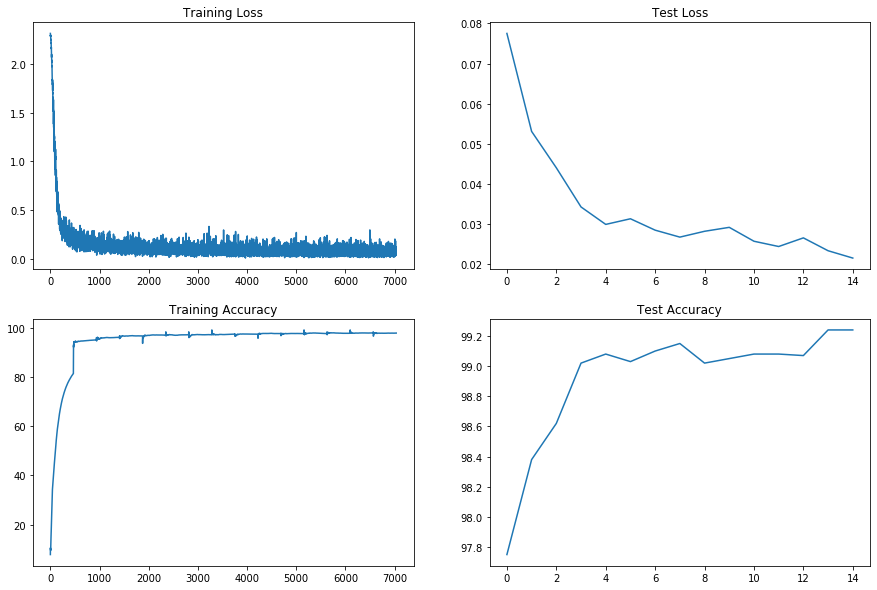

In [17]:
## Plot the accuracy graphs 

import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

##